In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [14]:
# 设置数据路径
big_images_path = "E:\metamaterialpicture\metamaterialpicture900features\900features"
small_images_path = "E:\metamaterialpicture\metamaterialpicture900features"

In [15]:
def load_data():
    big_images = []
    small_images = []
    for i in range(1, 200):
        big_img_path = os.path.join(big_images_path, f"lcy{i}.jpg")
        small_img_path = os.path.join(small_images_path, f"lcy{i}.jpg")

        big_img = cv2.imread(big_img_path, cv2.IMREAD_GRAYSCALE)
        small_img = cv2.imread(small_img_path, cv2.IMREAD_GRAYSCALE)

        # 处理成适当的格式
        big_img = big_img / 255.0  # 归一化
        small_img = small_img / 255.0  # 归一化
        
        big_images.append(big_img)
        small_images.append(small_img)

    return np.array(big_images), np.array(small_images)
# 数据处理
big_images, small_images = load_data()

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(big_images, small_images, test_size=0.2, random_state=42)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train / 255.0
X_test = X_test / 255.0
X_train=np.array(X_train)
X_test=np.array(X_test)

y_train = np.expand_dims(y_train, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)
y_train = y_train / 255.0
y_test = y_test / 255.0
y_train=np.array(y_train)
y_test=np.array(y_test)


# 构建CNN模型
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(595, 595, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.AveragePooling2D((2, 2)),
])

In [ ]:
# 构建改进的U-Net模型
def improved_unet_model():
    inputs = Input((595, 595, 1))
    
    # 编码器
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = AveragePooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = AveragePooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = AveragePooling2D(pool_size=(2, 2))(conv3)
    
    # 中间层
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    
    # 解码器
    up1 = UpSampling2D((2, 2))(conv4)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(up1)
    conv5 = Conv2D(256, 3, activation='relu', padding='same')(conv5)
    concatenate1 = concatenate([conv3, conv5], axis=-1)
    
    up2 = UpSampling2D((2, 2))(concatenate1)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(up2)
    conv6 = Conv2D(128, 3, activation='relu', padding='same')(conv6)
    concatenate2 = concatenate([conv2, conv6], axis=-1)
    
    up3 = UpSampling2D((2, 2))(concatenate2)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(up3)
    conv7 = Conv2D(64, 3, activation='relu', padding='same')(conv7)
    concatenate3 = concatenate([conv1, conv7], axis=-1)
    
    # 输出层
    outputs = Conv2D(1, 1, activation='sigmoid')(concatenate3)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model


In [16]:
# 定义一个 R2ScoreCallback 回调函数
class R2ScoreCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epochs, logs=None):
        # 在每个训练周期结束时计算 R2 分数并输出
        X_test = self.validation_data[0]
        y_test = self.validation_data[1]
        y_pred = self.model.predict(X_test)
        y_test = y_test.flatten()
        y_pred = y_pred.flatten()
        r2 = r2_score(y_test, y_pred)
        print(f"Validation R2 Score: {r2}")
r2_callback = R2ScoreCallback()

In [17]:
# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

In [18]:
# 训练模型
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/20
5/5 [==============================] - 53s 11s/step - loss: 0.2852 - mae: 0.3381 - val_loss: 0.2294 - val_mae: 0.4778
Epoch 2/20
5/5 [==============================] - 56s 11s/step - loss: 0.2183 - mae: 0.2204 - val_loss: 0.1782 - val_mae: 0.4029
Epoch 3/20
5/5 [==============================] - 53s 11s/step - loss: 0.1834 - mae: 0.1851 - val_loss: 0.1480 - val_mae: 0.3235
Epoch 4/20
5/5 [==============================] - 54s 11s/step - loss: 0.1729 - mae: 0.1744 - val_loss: 0.1385 - val_mae: 0.2609
Epoch 5/20
5/5 [==============================] - 53s 11s/step - loss: 0.1654 - mae: 0.1669 - val_loss: 0.1386 - val_mae: 0.2205
Epoch 6/20
5/5 [==============================] - 53s 11s/step - loss: 0.1596 - mae: 0.1611 - val_loss: 0.1416 - val_mae: 0.1973
Epoch 7/20
5/5 [==============================] - 57s 12s/step - loss: 0.1581 - mae: 0.1596 - val_loss: 0.1439 - val_mae: 0.1832
Epoch 8/20
5/5 [==============================] - 53s 11s/step - loss: 0.1529 - mae: 0.1545 - val

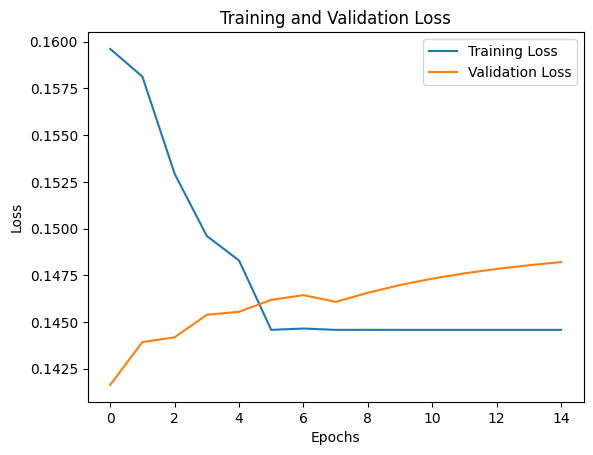

In [19]:
plt.plot(history.history['loss'][5:], label='Training Loss')
plt.plot(history.history['val_loss'][5:], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
# 在训练集上计算 R² 分数
y_train_pred = model.predict(X_train)
y_train = y_train.flatten()
y_train_pred =y_train_pred.flatten()
r2_train = r2_score(y_train, y_train_pred)

# 在验证集上计算 R² 分数
y_test_pred = model.predict(X_test)
y_test = y_test.flatten()
y_test_pred =y_test_pred.flatten()
r2_test = r2_score(y_test, y_test_pred)

# 打印 R² 分数
print(f'R² 分数 - 训练集: {r2_train:.4f}')
print(f'R² 分数 - 验证集: {r2_test:.4f}')

2/2 [==============================] - 3s 580ms/step
R² 分数 - 训练集: -86424.5821
R² 分数 - 验证集: -86378.3484
